# Green River Mammmoth Cave USGS Gauge Data (Site 03309000) Anlysis of flood events since removal of L&D6

In [1]:
## Installing libraries
# Install as needed.

!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install requests

In [2]:
# Import Libraries and print Versions
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import numpy as np
import os
import sys
import requests
import json

print("Python version: ", sys.version)
print("Pandas version: ", pd.__version__)
import matplotlib
print("Matplotlib version: ", matplotlib.__version__)
print("Numpy version: ", np.__version__)
print("OS version: ", os.uname())
print("OS name: ", os.name)
print("Current working directory: ", os.getcwd())
print("Python executable: ", sys.executable)
print("Python path: ", sys.path)
print("Python modules: ", sys.modules)
print("Python platform: ", sys.platform)
print("Python version: ", sys.version)
print("Python version info: ", sys.version_info)



Python version:  3.13.2 (main, Feb  4 2025, 14:51:09) [Clang 16.0.0 (clang-1600.0.26.6)]
Pandas version:  2.2.3
Matplotlib version:  3.10.1
Numpy version:  2.2.4
OS version:  posix.uname_result(sysname='Darwin', nodename='Raybiess-MacBook-Pro.local', release='24.4.0', version='Darwin Kernel Version 24.4.0: Wed Mar 19 21:16:34 PDT 2025; root:xnu-11417.101.15~1/RELEASE_ARM64_T6000', machine='arm64')
OS name:  posix
Current working directory:  /Users/raybies/CODE/GreenRiverFerryRiver/01_Scripts
Python executable:  /Users/raybies/CODE/GreenRiverFerryRiver/.venv/bin/python
Python path:  ['/opt/homebrew/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python313.zip', '/opt/homebrew/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13', '/opt/homebrew/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13/lib-dynload', '', '/Users/raybies/CODE/GreenRiverFerryRiver/.venv/lib/python3.13/site-packages']
Python modul

In [3]:
## USGS Gauge Data
url = 'https://nwis.waterservices.usgs.gov/nwis/iv/?sites=03309000&agencyCd=USGS&startDT=2018-01-01T00:00:00.000-06:00&endDT=2025-04-10T23:59:59.999-05:00&parameterCd=00055&format=rdb'

try: 
    response = requests.get(url)
    response.raise_for_status()  # Raise an error for bad responses
except requests.exceptions.RequestException as e:
    print(f"Error: {e}")
    # Handle the error appropriately (e.g., log it, retry, etc.)
    exit()

In [4]:
from io import StringIO

# Parse the response content and convert it into a DataFrame

# Decode the response content
content = response.content.decode('utf-8')

# Skip comment lines (lines starting with '#') and create a DataFrame
data_lines = "\n".join([line for line in content.splitlines() if not line.startswith('#')])
df = pd.read_csv(StringIO(data_lines), sep='\t')

# Display the first few rows of the DataFrame
print(df.head())

  agency_cd   site_no          datetime tz_cd 220641_00055 220641_00055_cd
0        5s       15s               20d    6s          14n             10s
1      USGS  03309000  2022-04-14 00:00   CDT         2.86               P
2      USGS  03309000  2022-04-14 00:15   CDT         2.93               P
3      USGS  03309000  2022-04-14 00:30   CDT         2.89               P
4      USGS  03309000  2022-04-14 00:45   CDT         2.91               P


In [5]:
# Rename columns for clarity
df = df.rename(columns={"220641_00055_cd":"approved", "tz_cd":"timezone", "220641_00055":"velocity"})

# Remove the first row of the DataFrame
df = df.iloc[1:]
# Reset the index of the DataFrame
df = df.reset_index(drop=True)
# Convert the 'dateTime' column to datetime format
df['datetime'] = pd.to_datetime(df['datetime'])
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['year'] = df['datetime'].dt.year
# Create a new DataFrame with the desired columns       
df2 = df[['datetime', 'velocity', 'month', 'day', 'year']]
df2.head()

,datetime,velocity,month,day,year
0,2022-04-14 00:00:00,2.86,4,14,2022
1,2022-04-14 00:15:00,2.93,4,14,2022
2,2022-04-14 00:30:00,2.89,4,14,2022
3,2022-04-14 00:45:00,2.91,4,14,2022
4,2022-04-14 01:00:00,2.90,4,14,2022


/var/folders/yb/x_108bl52f19_7x02z9s6byc0000gn/T/ipykernel_78144/2162694569.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['velocity'] = pd.to_numeric(df['velocity'], errors='coerce')
/var/folders/yb/x_108bl52f19_7x02z9s6byc0000gn/T/ipykernel_78144/2162694569.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


TypeError: ufunc 'divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

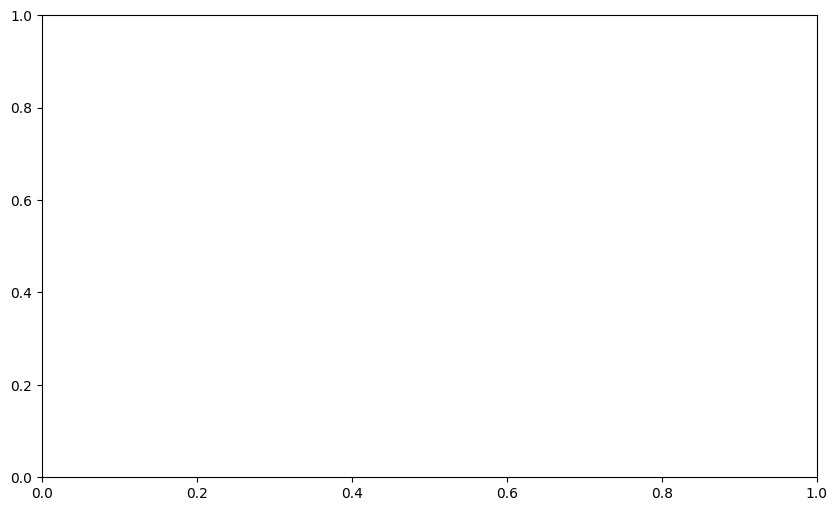

In [6]:
# Ensure the 'velocity' column is numeric
df2['velocity'] = pd.to_numeric(df['velocity'], errors='coerce')

# Create a DataFrame of the maximum veolcity value for each day
daily_max_df = df.groupby(df['datetime'].dt.date)['velocity'].max().reset_index()
daily_max_df.columns = ['date', 'max_daily_velocity']

# Add a month column to the daily_max_df
daily_max_df['month'] = pd.to_datetime(daily_max_df['date']).dt.month

# Group the maximum daily values by month
grouped_daily_max = daily_max_df.groupby('month')['max_daily_velocity']

# Create a boxplot of the maximum daily values grouped by month
plt.figure(figsize=(10, 6))
plt.boxplot(
    [group for _, group in grouped_daily_max],
    labels=grouped_daily_max.groups.keys(),
    flierprops={
        'marker': 'x',  # Outlier marker symbol
        'markerfacecolor': 'red',  # Outlier marker color
        'markeredgecolor': 'black',  # Outlier marker edge color
        'markersize': 3,  # Outlier marker size
        'alpha': 0.5  # Outlier opacity
    }
)
plt.title('Boxplot of Maximum Daily Velocity Values Grouped by Month')
plt.xlabel('Month')
plt.ylabel('Maximum Daily Velocity Value (feet per square inch)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Extract data for month 4
month_2_data = daily_max_df[daily_max_df['month'] == 2]['max_daily_velocity']

# Calculate Q1, Q3, and IQR
Q1 = month_2_data.quantile(0.25)
Q3 = month_2_data.quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = daily_max_df[(daily_max_df['month'] == 2) & 
                        ((daily_max_df['max_daily_velocity'] < lower_bound) | 
                         (daily_max_df['max_daily_velocity'] > upper_bound))]

# Output the rows for outliers
print(outliers)

            date  max_daily_gage  month
2583  2025-02-16           46.46      2
2584  2025-02-17           52.26      2
2585  2025-02-18           52.49      2
2586  2025-02-19           50.07      2


In [ ]:
# Extract data for month 4
month_4_data = daily_max_df[daily_max_df['month'] == 4]['max_daily_velocity']

# Calculate Q1, Q3, and IQR
Q1 = month_4_data.quantile(0.25)
Q3 = month_4_data.quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = daily_max_df[(daily_max_df['month'] == 4) & 
                        ((daily_max_df['max_daily_velocity'] < lower_bound) | 
                         (daily_max_df['max_daily_velocity'] > upper_bound))]

# Output the rows for outliers
print(outliers)

            date  max_daily_gage  month
2630  2025-04-04           47.73      4
2631  2025-04-05           57.67      4
2632  2025-04-06           59.54      4
2633  2025-04-07           58.99      4
2634  2025-04-08           55.82      4
2635  2025-04-09           49.47      4
2636  2025-04-10           37.50      4
